# March Madness Team Advancement Probabilities
## 1. Problem Statement
- This project understands how success in the NCAA College Basketball Tournament (how far a team goes) is affected by numerous team variables. This knowledge will then be used to predict team success in the 2024 College Basketball Tournament.

## 2. Data Collection
- Historical dataset source 1 - https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset
- Historical dataset source 2 and 2024 dataset source 1 - https://evanmiya.com/?team_ratings
- 2024 dataset source 2 - https://barttorvik.com/#

## 2.1 Import Data and Required Packages
### Importing Pandas, Numpy, Seaborn, Matplotlib, and Scikit-Learn

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer

pd.set_option('display.max_columns', 200)
# Define a formatting function to convert floating-point numbers to string representations
def format_float(x):
    return '{:.2f}'.format(x)

# Set the display option to use the formatting function for floating-point numbers
pd.set_option('display.float_format', format_float)

### Import the CSV Data as Pandas DataFrame

In [120]:
df = pd.read_csv('data/cbb.csv')
df_em = pd.read_csv('data/evanmiya_final.csv')


In [121]:
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.30,94.90,0.95,52.60,48.10,15.40,18.20,40.70,30.00,32.30,30.40,53.90,44.60,32.70,36.20,71.70,8.60,2ND,1.00,2016
1,Wisconsin,B10,40,36,129.10,93.60,0.98,54.80,47.70,12.40,15.80,32.10,23.70,36.20,22.40,54.80,44.70,36.50,37.50,59.30,11.30,2ND,1.00,2015
2,Michigan,B10,40,33,114.40,90.40,0.94,53.90,47.70,14.00,19.50,25.50,24.90,30.70,30.00,54.70,46.80,35.20,33.20,65.90,6.90,2ND,3.00,2018
3,Texas Tech,B12,38,31,115.20,85.20,0.97,53.50,43.00,17.70,22.80,27.40,28.70,32.90,36.60,52.80,41.90,36.50,29.70,67.50,7.00,2ND,3.00,2019
4,Gonzaga,WCC,39,37,117.80,86.30,0.97,56.60,41.10,16.20,17.10,30.00,26.20,39.00,26.90,56.30,40.00,38.20,29.00,71.50,7.70,2ND,1.00,2017


In [122]:
df_em.head()

,RANK,TEAM,YEAR,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,1,Louisville,2013,12.18,15.32,27.50,5.98,-16.03,236
1,2,Kansas,2013,11.95,14.74,26.69,72.45,-4.28,11
2,3,Gonzaga,2013,16.09,9.72,25.81,11.60,-8.95,107
3,4,Michigan,2013,17.87,6.72,24.59,33.56,6.82,68
4,5,Florida,2013,12.40,12.02,24.42,-68.06,-50.92,31


In [123]:
df.shape , df_em.shape

((3523, 24), (3522, 9))

### Combine the Two DataFrames

In [124]:
df = pd.merge(df, df_em, on=['TEAM', 'YEAR'], how='inner')
df.columns = df.columns.astype(str)
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,RANK,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,North Carolina,ACC,40,33,123.30,94.90,0.95,52.60,48.10,15.40,18.20,40.70,30.00,32.30,30.40,53.90,44.60,32.70,36.20,71.70,8.60,2ND,1.00,2016,2,18.83,9.85,28.67,79.73,-2.04,116
1,Wisconsin,B10,40,36,129.10,93.60,0.98,54.80,47.70,12.40,15.80,32.10,23.70,36.20,22.40,54.80,44.70,36.50,37.50,59.30,11.30,2ND,1.00,2015,4,23.12,7.66,30.78,29.47,28.46,136
2,Michigan,B10,40,33,114.40,90.40,0.94,53.90,47.70,14.00,19.50,25.50,24.90,30.70,30.00,54.70,46.80,35.20,33.20,65.90,6.90,2ND,3.00,2018,7,11.51,12.25,23.76,29.19,54.98,146
3,Texas Tech,B12,38,31,115.20,85.20,0.97,53.50,43.00,17.70,22.80,27.40,28.70,32.90,36.60,52.80,41.90,36.50,29.70,67.50,7.00,2ND,3.00,2019,5,9.64,16.55,26.18,54.33,-63.17,49
4,Gonzaga,WCC,39,37,117.80,86.30,0.97,56.60,41.10,16.20,17.10,30.00,26.20,39.00,26.90,56.30,40.00,38.20,29.00,71.50,7.70,2ND,1.00,2017,1,12.64,15.58,28.22,-3.53,-54.23,293


## 2.2 Dataset Information
- RK (Only in cbb20): The ranking of the team at the end of the regular season according to barttorvik
- TEAM: The Division I college basketball school
- CONF: Conference Team is in 
- G: Number of games played
- W: Number of games won
- ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)
- ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)
- BARTHAG: Power Rating (Chance of beating an average Division I team)
- EFG_O: Effective Field Goal Percentage Shot
- EFG_D: Effective Field Goal Percentage Allowed
- TOR: Turnover Percentage Allowed (Turnover Rate)
- TORD: Turnover Percentage Committed (Steal Rate)
- ORB: Offensive Rebound Rate
- DRB: Offensive Rebound Rate Allowed
- FTR : Free Throw Rate (How often the given team shoots Free Throws)
- FTRD: Free Throw Rate Allowed
- 2P_O: Two-Point Shooting Percentage
- 2P_D: Two-Point Shooting Percentage Allowed
- 3P_O: Three-Point Shooting Percentage
- 3P_D: Three-Point Shooting Percentage Allowed
- ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)
- OBPR: Teams expected offensive efficiency (Points per 100 possesions better than average)
- DBPR: Teams expected defensive efficiency
- BPR: Sum of OBPR and DBPR
- WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)
- POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)
- SEED: Seed in the NCAA March Madness Tournament
- YEAR: Season
- RANK: rank for the year per Evan Miya
- OBPR: Expected offensive efficiency against similar ranked teams
- DBPR: Expected defensive efficiency against similar ranked teams
- BPR: Overall strength relative to similarly ranked teams
- OPPONENT_ADJUST: How well each team performs above or below expectation vs above average or below average opponents (positive is better against better opponents)
- PACE_ADJUST: How well each team performs above or below expectation in fast pace vs slow paced games (positive is better in fast paced games)

## 3. Data Checks
### 3.1 Check Missing Values

In [125]:
df.isna().sum()

TEAM                  0
CONF                  0
G                     0
W                     0
ADJOE                 0
ADJDE                 0
BARTHAG               0
EFG_O                 0
EFG_D                 0
TOR                   0
TORD                  0
ORB                   0
DRB                   0
FTR                   0
FTRD                  0
2P_O                  0
2P_D                  0
3P_O                  0
3P_D                  0
ADJ_T                 0
WAB                   0
POSTSEASON         2571
SEED               2571
YEAR                  0
RANK                  0
OBPR                  0
DBPR                  0
BPR                   0
OPPONENT_ADJUST       0
PACE_ADJUST           0
HOME_RANK             0
dtype: int64

### Data set contains teams who did not make the tournament. Remove those teams. 

In [126]:
df = df.dropna(subset=['POSTSEASON'])
df.isna().sum()

TEAM               0
CONF               0
G                  0
W                  0
ADJOE              0
ADJDE              0
BARTHAG            0
EFG_O              0
EFG_D              0
TOR                0
TORD               0
ORB                0
DRB                0
FTR                0
FTRD               0
2P_O               0
2P_D               0
3P_O               0
3P_D               0
ADJ_T              0
WAB                0
POSTSEASON         0
SEED               0
YEAR               0
RANK               0
OBPR               0
DBPR               0
BPR                0
OPPONENT_ADJUST    0
PACE_ADJUST        0
HOME_RANK          0
dtype: int64

### There are no more missing values

### 3.2 Remove R68 Teams
Also remove teams who lost in the First Four games (R68). Only eight teams play in this wild card round each year so we will remove it for simplicity. 

In [127]:
df = df[df['POSTSEASON'] != 'R68']

### 3.3 Check Duplicates

In [128]:
df.duplicated(subset=['TEAM', 'YEAR']).sum()

0

### There are no duplicates

### 3.4 Remove Unwanted Columns

In [129]:

df = df.drop(columns=['YEAR', 'TEAM', 'G', 'W', 'CONF'])

### 3.5 Check Data Types

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619 entries, 0 to 2954
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ADJOE            619 non-null    float64
 1   ADJDE            619 non-null    float64
 2   BARTHAG          619 non-null    float64
 3   EFG_O            619 non-null    float64
 4   EFG_D            619 non-null    float64
 5   TOR              619 non-null    float64
 6   TORD             619 non-null    float64
 7   ORB              619 non-null    float64
 8   DRB              619 non-null    float64
 9   FTR              619 non-null    float64
 10  FTRD             619 non-null    float64
 11  2P_O             619 non-null    float64
 12  2P_D             619 non-null    float64
 13  3P_O             619 non-null    float64
 14  3P_D             619 non-null    float64
 15  ADJ_T            619 non-null    float64
 16  WAB              619 non-null    float64
 17  POSTSEASON       619

### 3.6 Ordinally Encode 'POSTSEASON' Variable

In [131]:
categories = ['R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champions']

ordinal_encoder = OrdinalEncoder(categories=[categories])
ordinal_encoder.fit(df[['POSTSEASON']])
df['POSTSEASON'] = ordinal_encoder.transform(df[['POSTSEASON']])


In [132]:
df['POSTSEASON']

0      5.00
1      5.00
2      5.00
3      5.00
4      5.00
       ... 
2950   0.00
2951   2.00
2952   1.00
2953   0.00
2954   0.00
Name: POSTSEASON, Length: 619, dtype: float64

### 3.8 Correlation and Heatmap
### Check for extreme correlations between independent variables

d:\MMPredictionsProject\venv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

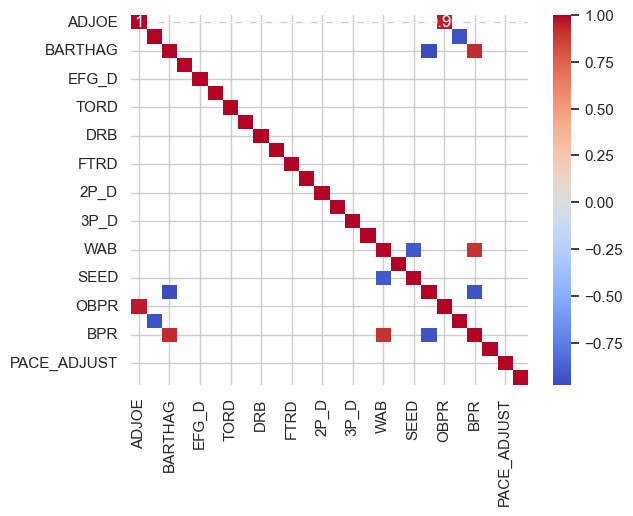

In [133]:
df_no_conf = df.filter(regex='^(?!CONF).*', axis=1)
corr_matrix = df_no_conf.corr()
filtered_corr_matrix = corr_matrix[(corr_matrix > 0.9) | (corr_matrix < -0.9)]
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')

In [134]:
df_no_conf.corr()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,RANK,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
ADJOE,1.00,-0.24,0.76,0.56,-0.00,-0.47,-0.21,0.22,-0.04,-0.12,-0.21,0.46,-0.03,0.45,0.04,0.12,0.75,0.51,-0.74,-0.75,0.96,0.32,0.81,-0.04,0.06,-0.14
ADJDE,-0.24,1.00,-0.75,0.17,0.70,-0.05,-0.28,-0.30,0.13,0.03,0.04,0.09,0.62,0.19,0.44,0.19,-0.69,-0.41,0.67,0.70,-0.28,-0.94,-0.72,0.03,-0.10,0.18
BARTHAG,0.76,-0.75,1.00,0.22,-0.39,-0.27,0.02,0.29,-0.12,-0.11,-0.15,0.22,-0.37,0.14,-0.21,-0.03,0.88,0.47,-0.84,-0.97,0.76,0.76,0.93,-0.04,0.12,-0.20
EFG_O,0.56,0.17,0.22,1.00,0.18,-0.24,-0.28,-0.31,-0.25,-0.25,-0.31,0.87,0.16,0.72,0.10,0.16,0.26,0.21,-0.20,-0.25,0.58,-0.14,0.30,-0.10,-0.05,-0.03
EFG_D,-0.00,0.70,-0.39,0.18,1.00,-0.19,-0.00,-0.32,0.04,-0.15,-0.03,0.12,0.88,0.16,0.61,0.23,-0.38,-0.22,0.35,0.36,-0.04,-0.68,-0.41,0.05,-0.04,0.11
TOR,-0.47,-0.05,-0.27,-0.24,-0.19,1.00,0.15,0.30,0.13,0.30,0.22,-0.16,-0.17,-0.24,-0.11,-0.01,-0.28,-0.19,0.26,0.29,-0.44,-0.04,-0.31,0.02,0.01,0.01
TORD,-0.21,-0.28,0.02,-0.28,-0.00,0.15,1.00,0.17,0.40,0.06,0.45,-0.20,0.05,-0.25,-0.11,-0.01,0.00,0.04,-0.00,0.00,-0.19,0.24,0.01,-0.02,0.03,-0.04
ORB,0.22,-0.30,0.29,-0.31,-0.32,0.30,0.17,1.00,0.17,0.29,0.27,-0.25,-0.32,-0.23,-0.13,-0.02,0.30,0.19,-0.31,-0.28,0.21,0.33,0.33,-0.04,0.15,-0.11
DRB,-0.04,0.13,-0.12,-0.25,0.04,0.13,0.40,0.17,1.00,0.26,0.32,-0.27,0.04,-0.11,0.02,0.09,-0.12,0.01,0.06,0.13,-0.07,-0.12,-0.11,0.07,-0.04,-0.02
FTR,-0.12,0.03,-0.11,-0.25,-0.15,0.30,0.06,0.29,0.26,1.00,0.39,-0.22,-0.20,-0.15,0.05,0.02,-0.05,-0.08,0.06,0.12,-0.15,-0.00,-0.10,0.02,0.03,-0.02


### Drop one of the features in an above 0.9 correlation pair

In [135]:
df = df.drop(columns=['WAB', 'RANK'])


d:\MMPredictionsProject\venv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

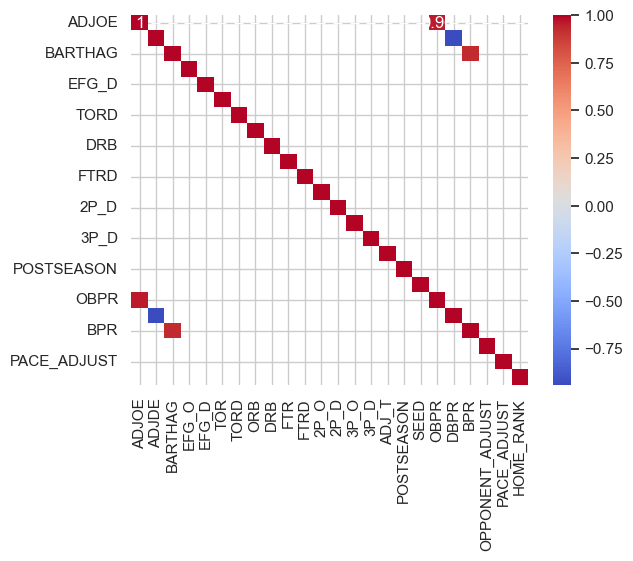

In [136]:
df_no_conf = df.filter(regex='^(?!CONF).*', axis=1)
corr_matrix = df_no_conf.corr()
filtered_corr_matrix = corr_matrix[(corr_matrix > 0.9) | (corr_matrix < -0.9)]
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')

In [137]:
df_no_conf.corr()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,POSTSEASON,SEED,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
ADJOE,1.00,-0.24,0.76,0.56,-0.00,-0.47,-0.21,0.22,-0.04,-0.12,-0.21,0.46,-0.03,0.45,0.04,0.12,0.51,-0.74,0.96,0.32,0.81,-0.04,0.06,-0.14
ADJDE,-0.24,1.00,-0.75,0.17,0.70,-0.05,-0.28,-0.30,0.13,0.03,0.04,0.09,0.62,0.19,0.44,0.19,-0.41,0.67,-0.28,-0.94,-0.72,0.03,-0.10,0.18
BARTHAG,0.76,-0.75,1.00,0.22,-0.39,-0.27,0.02,0.29,-0.12,-0.11,-0.15,0.22,-0.37,0.14,-0.21,-0.03,0.47,-0.84,0.76,0.76,0.93,-0.04,0.12,-0.20
EFG_O,0.56,0.17,0.22,1.00,0.18,-0.24,-0.28,-0.31,-0.25,-0.25,-0.31,0.87,0.16,0.72,0.10,0.16,0.21,-0.20,0.58,-0.14,0.30,-0.10,-0.05,-0.03
EFG_D,-0.00,0.70,-0.39,0.18,1.00,-0.19,-0.00,-0.32,0.04,-0.15,-0.03,0.12,0.88,0.16,0.61,0.23,-0.22,0.35,-0.04,-0.68,-0.41,0.05,-0.04,0.11
TOR,-0.47,-0.05,-0.27,-0.24,-0.19,1.00,0.15,0.30,0.13,0.30,0.22,-0.16,-0.17,-0.24,-0.11,-0.01,-0.19,0.26,-0.44,-0.04,-0.31,0.02,0.01,0.01
TORD,-0.21,-0.28,0.02,-0.28,-0.00,0.15,1.00,0.17,0.40,0.06,0.45,-0.20,0.05,-0.25,-0.11,-0.01,0.04,-0.00,-0.19,0.24,0.01,-0.02,0.03,-0.04
ORB,0.22,-0.30,0.29,-0.31,-0.32,0.30,0.17,1.00,0.17,0.29,0.27,-0.25,-0.32,-0.23,-0.13,-0.02,0.19,-0.31,0.21,0.33,0.33,-0.04,0.15,-0.11
DRB,-0.04,0.13,-0.12,-0.25,0.04,0.13,0.40,0.17,1.00,0.26,0.32,-0.27,0.04,-0.11,0.02,0.09,0.01,0.06,-0.07,-0.12,-0.11,0.07,-0.04,-0.02
FTR,-0.12,0.03,-0.11,-0.25,-0.15,0.30,0.06,0.29,0.26,1.00,0.39,-0.22,-0.20,-0.15,0.05,0.02,-0.08,0.06,-0.15,-0.00,-0.10,0.02,0.03,-0.02


## 4. Exploratory Data Analysis

### BPR vs Games Won Scatterplot

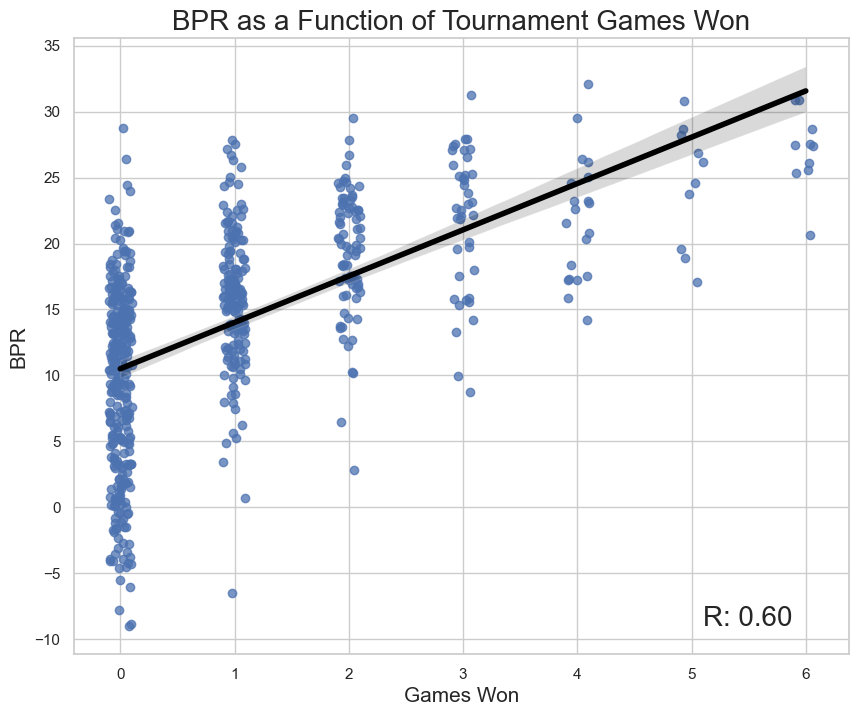

In [138]:
from scipy.stats import pearsonr

sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 8))

sns.regplot(data=df, x='POSTSEASON', y = 'BPR', x_jitter=0.1,
            scatter_kws={'alpha': 0.75},
            line_kws={'lw': 4, 'color':'black'})

corr_coef, _ = pearsonr(df['POSTSEASON'], df['BPR'])

# Annotate the plot with the correlation coefficient
plt.text(5.1, -9, f'R: {corr_coef:.2f}', fontsize=20)

plt.yticks([-10, -5, 0, 5, 10, 15, 20, 25, 30, 35])
plt.xlabel('Games Won', fontsize=15)
plt.ylabel("BPR", fontsize=15)
plt.title("BPR as a Function of Tournament Games Won", fontsize=20)
plt.show()

### Evaluate top 4 seeds who did and did not make the final four

In [139]:
scaler = StandardScaler()

df_top4 = df[df['SEED'] <= 4]
df_top4 = pd.DataFrame(scaler.fit_transform(df_top4), columns=df_top4.columns)

In [140]:
df_top4_f4 = df_top4[df_top4['POSTSEASON'] > 0.53] #0.53
del df_top4_f4['POSTSEASON']
del df_top4_f4['SEED']
df_top4_f4.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,1.32,0.62,0.70,-0.26,0.67,-0.86,-0.31,2.02,0.72,-0.62,-0.07,0.41,-0.34,-1.46,1.79,1.18,1.72,-0.03,1.51,2.12,-0.01,-0.22
1,2.57,0.28,1.46,0.55,0.49,-2.58,-1.25,-0.23,-1.62,0.14,-1.52,0.70,-0.30,0.06,2.40,-2.46,2.85,-0.68,2.01,0.77,0.86,-0.02
2,-0.61,-0.56,0.17,0.22,0.49,-1.66,0.19,-1.95,-1.17,-0.93,-0.15,0.67,0.48,-0.46,0.39,-0.52,-0.23,0.69,0.35,0.76,1.62,0.09
3,-0.44,-1.93,1.25,0.08,-1.56,0.46,1.49,-1.46,0.24,-0.50,1.05,0.06,-1.34,0.06,-1.24,-0.05,-0.72,1.96,0.92,1.44,-1.76,-0.90
4,0.12,-1.64,1.36,1.22,-2.39,-0.40,-0.75,-0.78,-0.69,0.69,-0.71,1.18,-2.05,0.74,-1.57,1.12,0.08,1.68,1.41,-0.12,-1.50,1.58


In [141]:
df_top4_no = df_top4[df_top4['POSTSEASON'] < 0.53]
del df_top4_no['POSTSEASON']
del df_top4_no['SEED']
df_top4_no.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
12,-1.69,-1.35,-0.11,-2.06,-1.12,0.18,0.90,0.45,1.02,0.63,0.45,-1.34,-0.82,-2.26,-0.96,-0.61,-1.15,1.22,-0.06,-0.91,0.59,1.37
13,1.75,1.59,0.26,1.84,0.58,-1.37,-0.67,-1.33,1.53,0.24,-1.21,1.78,0.71,1.06,0.11,-1.11,2.27,-1.75,0.64,0.65,1.39,0.70
14,0.58,-0.40,0.93,0.55,0.80,-1.03,-0.08,-0.80,-1.06,-0.66,0.47,-0.00,0.30,1.58,1.09,-1.70,0.57,0.91,1.24,0.82,-1.23,-1.17
15,1.10,0.10,0.90,0.96,-0.07,0.35,-0.67,1.52,0.72,-0.17,-1.54,1.08,-0.04,0.34,-0.17,0.94,1.20,0.32,1.33,-1.12,-1.36,-1.29
16,0.36,-0.88,1.09,0.11,-0.68,0.35,0.16,0.69,0.53,-0.44,-1.23,1.72,-0.19,-2.22,-1.15,1.74,-0.30,0.79,0.36,-1.27,-1.51,0.73


In [142]:
f4_means = pd.DataFrame(df_top4_f4.mean(), columns=['Mean'])
f4_means.head(20)

,Mean
ADJOE,0.75
ADJDE,-0.35
BARTHAG,0.89
EFG_O,0.41
EFG_D,-0.27
TOR,-0.35
TORD,0.12
ORB,0.11
DRB,0.13
FTR,-0.30


In [143]:
nof4_means = pd.DataFrame(df_top4_no.mean(), columns=['Mean'])
nof4_means.head(20)

,Mean
ADJOE,-0.15
ADJDE,0.07
BARTHAG,-0.18
EFG_O,-0.08
EFG_D,0.06
TOR,0.07
TORD,-0.02
ORB,-0.02
DRB,-0.03
FTR,0.06


In [144]:
f4_diff_df = f4_means - nof4_means

f4_diff_df = f4_diff_df.T

f4_diff_df.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
Mean,0.90,-0.42,1.08,0.49,-0.33,-0.42,0.15,0.14,0.16,-0.37,-0.38,0.39,-0.20,0.32,-0.30,-0.21,0.93,0.44,1.18,0.53,-0.18,-0.03


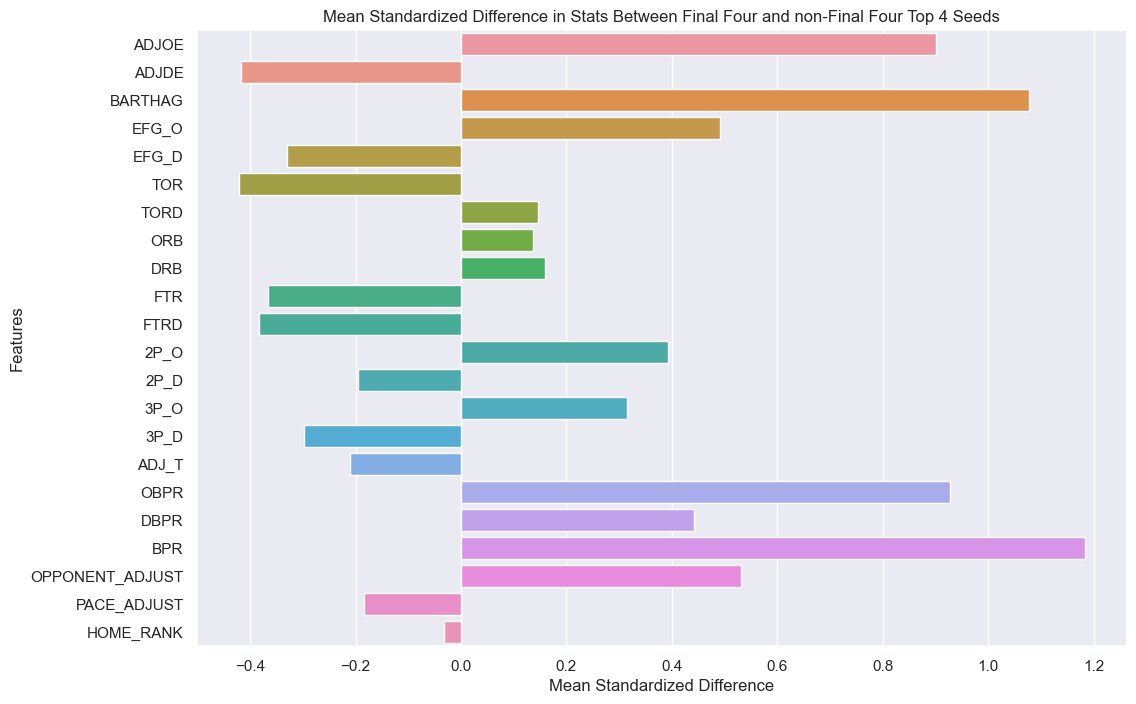

In [145]:
sns.set(style='darkgrid', context='notebook')

plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(data=f4_diff_df, orient='h')
# Set the y-tick labels
ax.set_yticklabels(f4_diff_df.columns)

# Set the labels and title
plt.xlabel('Mean Standardized Difference')
plt.ylabel('Features')
plt.title('Mean Standardized Difference in Stats Between Final Four and non-Final Four Top 4 Seeds')

# Show the plot
plt.show()



Fairly notably, offensive teams tend to do better than their defensive-oriented counterparts.

### Evaluate National Champs vs Non-National Champs

In [146]:
df_top2 = df[df['SEED'] <= 2]
df_top2 = pd.DataFrame(scaler.fit_transform(df_top2), columns=df_top2.columns)

df_top2.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,POSTSEASON,SEED,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,1.09,0.92,0.21,-0.57,0.90,-0.78,-0.25,2.04,0.86,-0.57,0.16,0.18,-0.13,-1.64,1.89,1.04,1.40,-0.99,1.54,-0.29,1.18,1.98,0.13,-0.31
1,2.55,0.55,1.54,0.34,0.73,-2.75,-1.25,-0.32,-1.59,0.12,-1.43,0.47,-0.09,-0.11,2.48,-2.26,1.40,-0.99,2.88,-0.98,1.79,0.67,0.97,-0.10
2,-0.30,-1.56,1.36,1.08,-2.13,-0.26,-0.71,-0.90,-0.61,0.62,-0.54,0.96,-1.82,0.58,-1.39,0.99,1.40,-0.99,-0.38,1.53,1.05,-0.20,-1.29,1.51
3,1.57,-0.32,1.57,1.08,0.21,-0.19,-0.08,0.69,0.94,0.77,-1.13,0.83,0.50,0.78,-0.29,-0.37,1.97,-0.99,2.12,-0.17,1.82,0.62,-2.05,-1.07
4,1.01,-0.52,1.41,0.50,-0.57,-1.24,-0.54,-0.79,-0.93,-1.15,-0.66,-0.28,0.28,1.10,-1.43,-1.89,1.97,-0.99,0.32,0.56,0.81,-0.44,0.00,1.65


In [147]:
df_top2_champ = df_top2[df_top2['POSTSEASON'] > 1.8] 

df_top2_champ = df_top2_champ.drop(columns=['POSTSEASON', 'SEED'])

df_top2_champ.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
3,1.57,-0.32,1.57,1.08,0.21,-0.19,-0.08,0.69,0.94,0.77,-1.13,0.83,0.50,0.78,-0.29,-0.37,2.12,-0.17,1.82,0.62,-2.05,-1.07
4,1.01,-0.52,1.41,0.50,-0.57,-1.24,-0.54,-0.79,-0.93,-1.15,-0.66,-0.28,0.28,1.10,-1.43,-1.89,0.32,0.56,0.81,-0.44,0.00,1.65
5,0.51,-0.06,0.70,-0.94,0.90,-0.26,-0.08,2.20,-1.08,-0.22,0.40,-0.77,0.50,-0.51,0.84,1.34,0.59,0.33,0.86,-0.37,0.39,-1.46
6,1.04,-0.23,1.21,0.87,0.29,-0.19,0.76,-1.39,0.63,-0.25,0.08,1.32,-0.31,-0.23,0.84,-0.29,0.81,0.48,1.19,1.85,-1.80,0.37
7,2.38,0.69,1.34,2.27,1.07,-1.05,-0.25,-1.01,-0.26,-1.09,-0.58,1.84,1.50,1.34,-0.16,0.49,2.22,-0.28,1.82,1.74,-1.56,0.63


In [148]:
df_top2_none = df_top2[df_top2['POSTSEASON'] < 1.9]

df_top2_none = df_top2_none.drop(columns=['POSTSEASON', 'SEED'])

df_top2_none.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,1.09,0.92,0.21,-0.57,0.90,-0.78,-0.25,2.04,0.86,-0.57,0.16,0.18,-0.13,-1.64,1.89,1.04,1.54,-0.29,1.18,1.98,0.13,-0.31
1,2.55,0.55,1.54,0.34,0.73,-2.75,-1.25,-0.32,-1.59,0.12,-1.43,0.47,-0.09,-0.11,2.48,-2.26,2.88,-0.98,1.79,0.67,0.97,-0.10
2,-0.30,-1.56,1.36,1.08,-2.13,-0.26,-0.71,-0.90,-0.61,0.62,-0.54,0.96,-1.82,0.58,-1.39,0.99,-0.38,1.53,1.05,-0.20,-1.29,1.51
9,0.23,-0.20,0.61,0.34,1.03,-0.98,0.00,-0.92,-1.00,-0.61,0.76,-0.25,0.50,1.43,1.21,-1.57,0.20,0.72,0.84,0.72,-1.03,-1.26
10,0.84,0.35,0.57,0.79,0.16,0.60,-0.63,1.52,0.86,-0.16,-1.45,0.86,0.17,0.17,-0.02,0.83,0.94,0.09,0.96,-1.17,-1.15,-1.39


In [149]:
champ_means = pd.DataFrame(df_top2_champ.mean(), columns=['Mean'])
champ_means.head(20)

,Mean
ADJOE,0.87
ADJDE,-0.23
BARTHAG,1.06
EFG_O,0.47
EFG_D,0.33
TOR,-0.08
TORD,0.67
ORB,0.27
DRB,0.37
FTR,-0.40


In [150]:
none_means = pd.DataFrame(df_top2_none.mean(), columns=['Mean'])
none_means.head(20)

,Mean
ADJOE,-0.10
ADJDE,0.03
BARTHAG,-0.12
EFG_O,-0.05
EFG_D,-0.04
TOR,0.01
TORD,-0.08
ORB,-0.03
DRB,-0.04
FTR,0.05


In [151]:
champ_diff_df = champ_means - none_means

champ_diff_df = champ_diff_df.T

champ_diff_df.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
Mean,0.97,-0.25,1.18,0.52,0.36,-0.09,0.75,0.30,0.41,-0.45,-0.11,0.34,0.50,0.40,-0.06,-0.04,0.91,0.26,1.09,0.67,-0.56,0.06


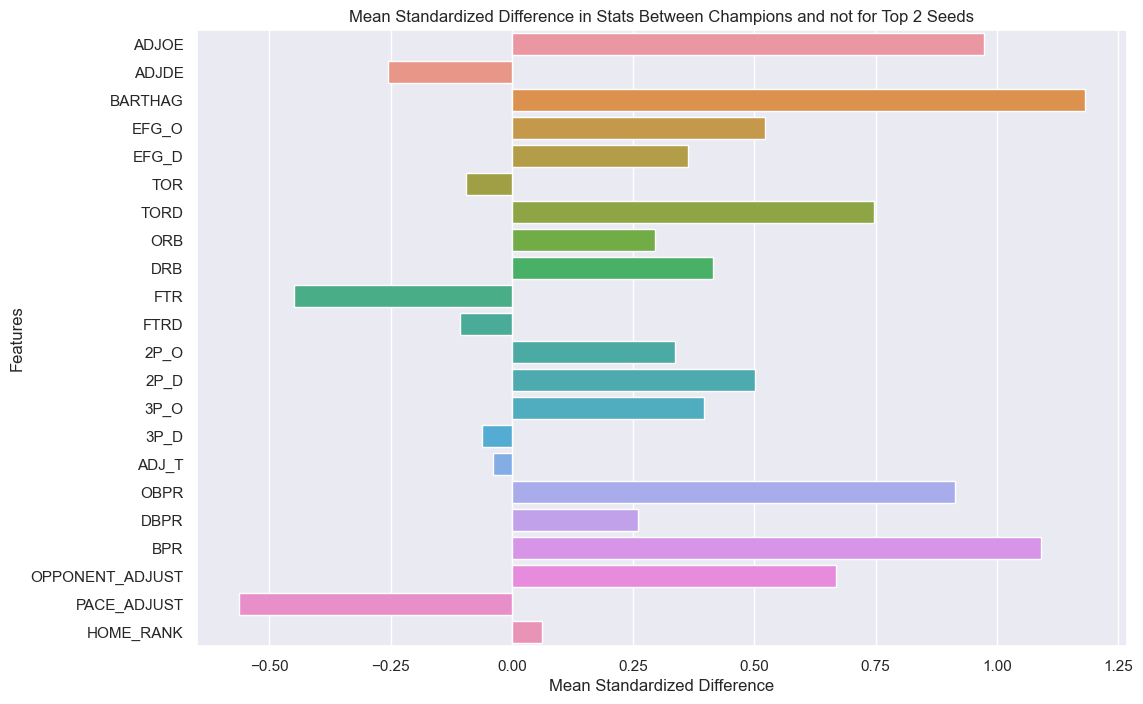

In [152]:
sns.set_theme(context='notebook', style='darkgrid')

plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(data=champ_diff_df, orient='h')
# Set the y-tick labels
ax.set_yticklabels(champ_diff_df.columns)

# Set the labels and title
plt.xlabel('Mean Standardized Difference')
plt.ylabel('Features')
plt.title('Mean Standardized Difference in Stats Between Champions and not for Top 2 Seeds')

# Show the plot
plt.show()

Some interesting insights. Again, offense seems to matter more than defense. Opponent adjust is a significant metric that is probably underrated. National champs are better in slow paced games. National champs are much better at rebounding and forcing turnovers. 

## Now lets look into upsets
### Look into stats of lower seeded teams who have been upset

In [153]:

df_6thru3 = df[(df['SEED'] <= 6) & (df['SEED'] >= 3)]
df_6thru3 = pd.DataFrame(scaler.fit_transform(df_6thru3), columns=df_6thru3.columns)
df_6thru3 = df_6thru3[df_6thru3['POSTSEASON'] < -0.91] # -0.91
df_6thru3 = df_6thru3.drop(columns=['POSTSEASON', 'SEED'])


In [154]:
df_top2 = df[df['SEED'] <= 2]
df_top2 = pd.DataFrame(scaler.fit_transform(df_top2), columns=df_top2.columns)
df_top2 = df_top2[df_top2['POSTSEASON'] < -0.9] # -0.9
df_top2 = df_top2.drop(columns=['POSTSEASON', 'SEED'])


In [155]:
df_upset = pd.concat([df_6thru3, df_top2])
df_upset.reset_index(drop=True, inplace=True)
df_upset.head()


,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,-0.75,0.27,-1.30,-0.07,-0.73,1.25,0.35,1.00,0.29,1.82,-0.13,-0.07,-1.29,0.21,-0.05,-1.27,-0.03,-0.10,-0.12,-0.19,0.13,0.07
1,1.24,0.14,1.18,0.87,-0.59,-0.21,-0.37,1.15,-0.70,0.20,-1.27,-0.18,-0.83,1.99,-0.34,-0.87,1.57,-0.04,1.58,1.27,-0.44,-0.63
2,1.45,2.41,-1.19,1.06,0.97,-0.43,-1.09,0.70,-2.03,-0.05,0.21,0.81,-0.09,0.96,1.67,0.89,1.72,-1.72,0.22,0.25,-0.70,0.97
3,0.62,-0.05,0.83,0.50,-1.37,0.24,-2.03,0.60,-1.75,0.08,-0.67,0.46,-1.29,0.38,-0.67,0.49,-0.12,0.77,0.57,-0.83,-1.14,-0.67
4,-0.24,1.14,-1.88,0.04,0.10,0.97,-0.48,-0.55,1.37,0.72,0.11,-0.18,-0.25,0.21,0.67,0.39,-0.63,-0.92,-1.48,0.91,-0.56,2.23


### Lower seeded teams who were not upset

In [156]:
df_6thru3_not = df[(df['SEED'] <= 6) & (df['SEED'] >= 3)]
df_6thru3_not = pd.DataFrame(scaler.fit_transform(df_6thru3_not), columns=df_6thru3_not.columns)
df_6thru3_not = df_6thru3_not[df_6thru3_not['POSTSEASON'] > -0.91] # -0.91
df_6thru3_not = df_6thru3_not.drop(columns=['POSTSEASON', 'SEED'])


In [157]:
df_top2_not = df[df['SEED'] <= 2]
df_top2_not = pd.DataFrame(scaler.fit_transform(df_top2_not), columns=df_top2_not.columns)
df_top2_not = df_top2_not[df_top2_not['POSTSEASON'] > -0.9] # -0.9
df_top2_not = df_top2_not.drop(columns=['POSTSEASON', 'SEED'])


In [158]:
df_notU = pd.concat([df_6thru3_not, df_top2_not])
df_notU.reset_index(drop=True, inplace=True)
df_notU.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
0,-0.01,-0.84,1.02,0.61,0.19,-1.84,0.06,-1.77,-1.23,-0.90,-0.34,1.12,0.22,-0.24,0.19,-0.51,0.41,1.07,1.39,0.89,1.66,0.19
1,0.17,-2.22,2.02,0.46,-1.96,0.24,1.25,-1.30,0.11,-0.44,0.80,0.46,-1.68,0.30,-1.49,0.02,-0.11,2.42,2.08,1.60,-2.28,-0.81
2,1.58,0.03,1.48,0.87,0.33,-1.50,-0.23,-0.02,0.36,-1.38,-1.60,0.67,0.53,0.88,-0.10,-0.87,2.16,-0.67,1.63,1.01,0.06,-0.62
3,-1.13,-1.64,0.75,-1.73,-1.51,-0.04,0.71,0.53,0.85,0.76,0.23,-1.09,-1.14,-2.10,-1.20,-0.61,-0.55,1.63,0.90,-0.86,0.47,1.49
4,2.43,1.33,1.10,2.27,0.28,-1.56,-0.73,-1.17,1.34,0.35,-1.36,2.36,0.45,1.33,-0.10,-1.17,3.00,-1.51,1.74,0.77,1.40,0.81


In [159]:
upset_means = pd.DataFrame(df_upset.mean(), columns=['Mean'])
upset_means.head(22)

,Mean
ADJOE,-0.34
ADJDE,0.14
BARTHAG,-0.54
EFG_O,-0.23
EFG_D,0.07
TOR,0.18
TORD,-0.06
ORB,0.00
DRB,-0.09
FTR,0.10


In [160]:
not_upset_means = pd.DataFrame(df_notU.mean(), columns=['Mean'])
not_upset_means.head(22)

,Mean
ADJOE,0.16
ADJDE,-0.07
BARTHAG,0.25
EFG_O,0.11
EFG_D,-0.03
TOR,-0.08
TORD,0.03
ORB,-0.00
DRB,0.04
FTR,-0.05


In [161]:
upset_diff_df = not_upset_means- upset_means

upset_diff_df = upset_diff_df.T

upset_diff_df.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
Mean,0.49,-0.21,0.79,0.34,-0.10,-0.26,0.08,-0.00,0.13,-0.14,-0.15,0.30,-0.09,0.20,-0.03,0.05,0.53,0.27,0.77,-0.07,-0.05,-0.44


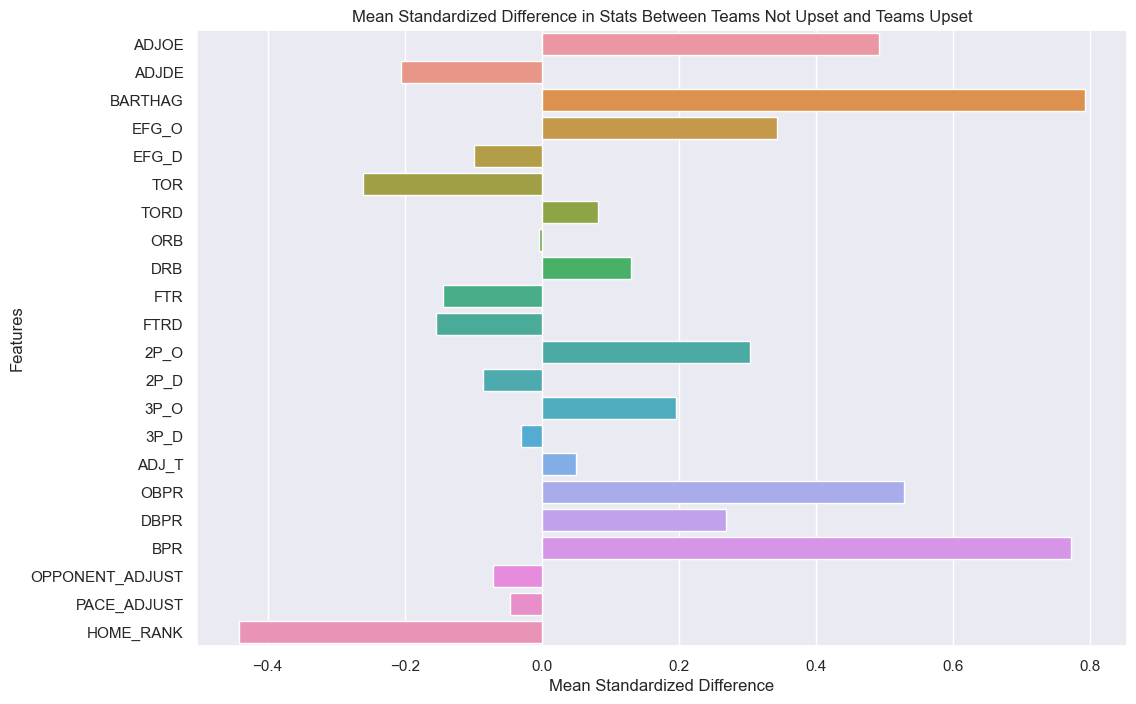

In [162]:
sns.set_theme(context='notebook', style='darkgrid')

plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(data=upset_diff_df, orient='h')
# Set the y-tick labels
ax.set_yticklabels(upset_diff_df.columns)

# Set the labels and title
plt.xlabel('Mean Standardized Difference')
plt.ylabel('Features')
plt.title('Mean Standardized Difference in Stats Between Teams Not Upset and Teams Upset')

# Show the plot
plt.show()

Teams who get upset are more likely to perform worse at home and turn the ball over at a higher rate. Also tend to be more defensive teams.

### Lets Look at Teams who Pulled Off Upsets

In [163]:
df_higher = df[df['SEED'] > 10]
df_higher = pd.DataFrame(scaler.fit_transform(df_higher), columns=df_higher.columns)

df_upsetters = df_higher[df_higher['POSTSEASON'] > 0.86]
df_upsetters = df_upsetters.drop(columns=['POSTSEASON', 'SEED'])


In [164]:
df_no = df_higher[df_higher['POSTSEASON'] < 0.86]
df_no = df_no.drop(columns=['POSTSEASON', 'SEED'])


In [165]:
upsetter_means = pd.DataFrame(df_upsetters.mean(), columns=['Mean'])
upsetter_means.head(22)

,Mean
ADJOE,0.53
ADJDE,-0.55
BARTHAG,0.71
EFG_O,0.05
EFG_D,-0.20
TOR,-0.13
TORD,0.19
ORB,0.09
DRB,0.07
FTR,-0.17


In [166]:
no_upset_means = pd.DataFrame(df_no.mean(), columns=['Mean'])
no_upset_means.head(22)

,Mean
ADJOE,-0.16
ADJDE,0.17
BARTHAG,-0.22
EFG_O,-0.02
EFG_D,0.06
TOR,0.04
TORD,-0.06
ORB,-0.03
DRB,-0.02
FTR,0.05


In [167]:
upsetter_diff_df = upsetter_means-  no_upset_means

upsetter_diff_df = upsetter_diff_df.T

upsetter_diff_df.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,OBPR,DBPR,BPR,OPPONENT_ADJUST,PACE_ADJUST,HOME_RANK
Mean,0.69,-0.72,0.93,0.07,-0.26,-0.16,0.25,0.11,0.10,-0.22,0.05,0.15,-0.10,-0.07,-0.37,-0.18,0.71,0.84,1.03,0.49,-0.21,-0.07


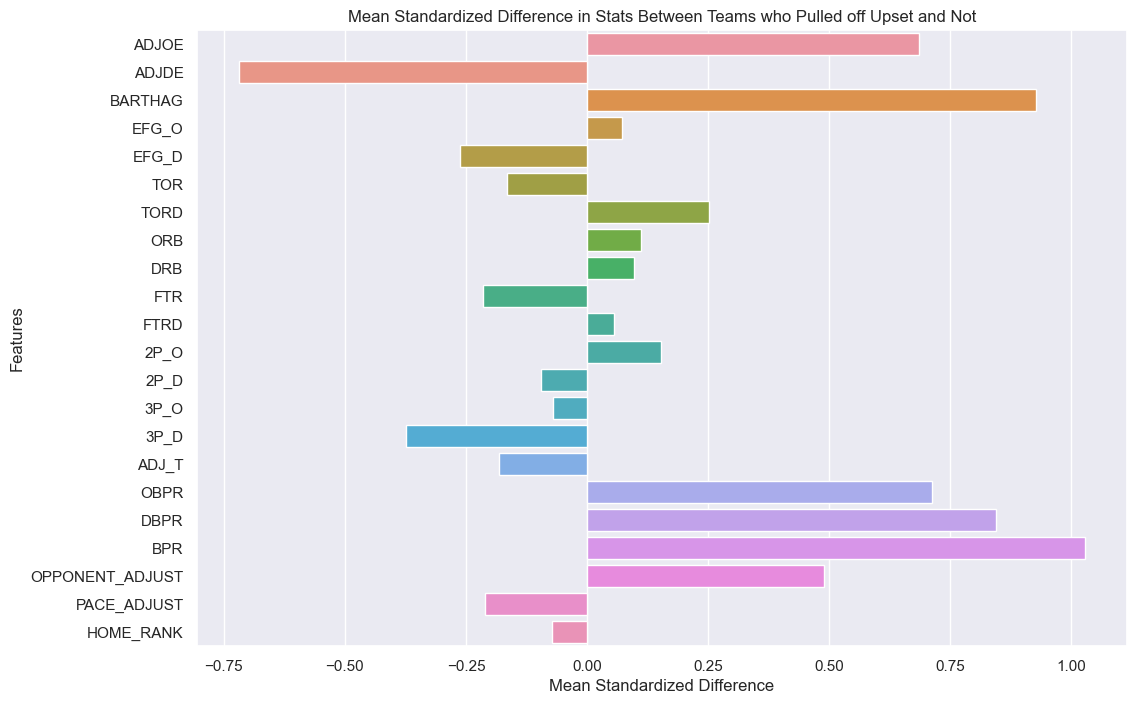

In [168]:
sns.set_theme(context='notebook', style='darkgrid')

plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(data=upsetter_diff_df, orient='h')
# Set the y-tick labels
ax.set_yticklabels(upsetter_diff_df.columns)

# Set the labels and title
plt.xlabel('Mean Standardized Difference')
plt.ylabel('Features')
plt.title('Mean Standardized Difference in Stats Between Teams who Pulled off Upset and Not')

# Show the plot
plt.show()

For the first time in this exploration, defense seems to matter more here. Opponent adjust also matters a ton, no surprise there. 

## 5. Random Forest Model Training
### 5.1 Split into train and test data

In [169]:
# Assign X and Y variables
X = df.drop('POSTSEASON', axis=1)

y = df['POSTSEASON']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [170]:
X_train.shape, X_test.shape


((495, 23), (124, 23))

### 5.2 Tune Paramters and Train Model

In [171]:
max_features_range = ['sqrt', 'auto', 'log2', None]
n_estimators_range = [50, 100, 200, 500, 1000]
max_depth_range = np.arange(4, 20, 2)
min_samples_leaf_range = [1, 2]
min_samples_split_range = np.arange(2, 10, 2)
bootstrap_range = [True, False]
criterion_range = ['gini', 'entropy']

param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, max_depth = max_depth_range, 
                  min_samples_leaf = min_samples_leaf_range, min_samples_split=min_samples_split_range, 
                  criterion = criterion_range, bootstrap = bootstrap_range)

### Create Custom Scorer
This scorer tries to mitigate the difference between the predicted round lost and actual round lost

In [172]:
def custom_mean_diff(y_true, y_pred):
    diff = abs(y_pred - y_true)
    mean_diff = diff.mean()
    return mean_diff

scorer = make_scorer(custom_mean_diff, greater_is_better=False)

In [173]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=7, scoring=scorer)

In [174]:
# grid.fit(X_train, y_train)

In [175]:
#grid.best_params_, grid.best_score_

In [176]:
rf = RandomForestClassifier(n_estimators= 100, max_features= None, max_depth= 14, min_samples_leaf= 1, min_samples_split= 6,
                            criterion= 'entropy', bootstrap= True, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=None,
                       min_samples_split=6, random_state=0)

### Save the model

In [177]:
#import joblib
#joblib.dump(rf, '../models/rf.pkl')

### 5.3 Evaluation of Model

In [178]:
y_pred_rf = rf.predict(X_test)

In [179]:
X_test_eval = X_test.copy()
X_test_eval['PRED'] = rf.predict(X_test)
test_data_eval = pd.merge(X_test_eval, y_test, left_index=True, right_index=True, how='inner')
test_data_eval['DIFF'] = test_data_eval['PRED'] - test_data_eval['POSTSEASON']

print("Off by an average of", '{:.4f}'.format(test_data_eval['DIFF'].mean()), "rounds")

Off by an average of -0.1694 rounds


In [180]:
print(confusion_matrix(y_test, y_pred_rf))
print()

[[50  6  4  0  0  0  1]
 [19  9  8  1  1  0  0]
 [ 3  3  3  1  0  0  0]
 [ 2  0  3  1  0  0  1]
 [ 1  0  1  0  0  0  1]
 [ 0  2  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]]



In [181]:
print(classification_report(y_test, y_pred_rf, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74        61
         1.0       0.45      0.24      0.31        38
         2.0       0.14      0.30      0.19        10
         3.0       0.25      0.14      0.18         7
         4.0       0.00      0.00      1.00         3
         5.0       1.00      0.00      0.00         4
         6.0       0.00      0.00      1.00         1

    accuracy                           0.51       124
   macro avg       0.36      0.21      0.49       124
weighted avg       0.52      0.51      0.51       124



d:\MMPredictionsProject\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


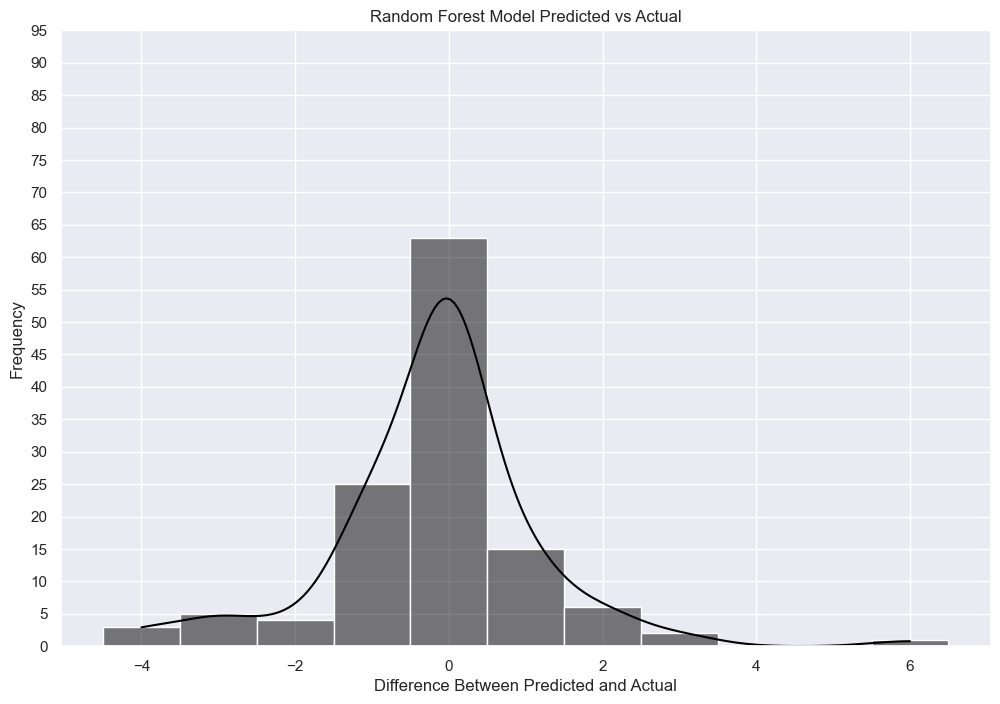

In [182]:
sns.set_theme(context='notebook', style='darkgrid')

plt.figure(figsize=(12, 8))

sns.histplot(test_data_eval['DIFF'], color='black', kde=True, fill=True, discrete=True)

plt.yticks(range(0, 100, 5))
plt.xlabel('Difference Between Predicted and Actual')
plt.ylabel('Frequency')
plt.title('Random Forest Model Predicted vs Actual')
plt.show()

Pretty good normal distribution of outcomes here. Slight bias towards underpredicting.

d:\MMPredictionsProject\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


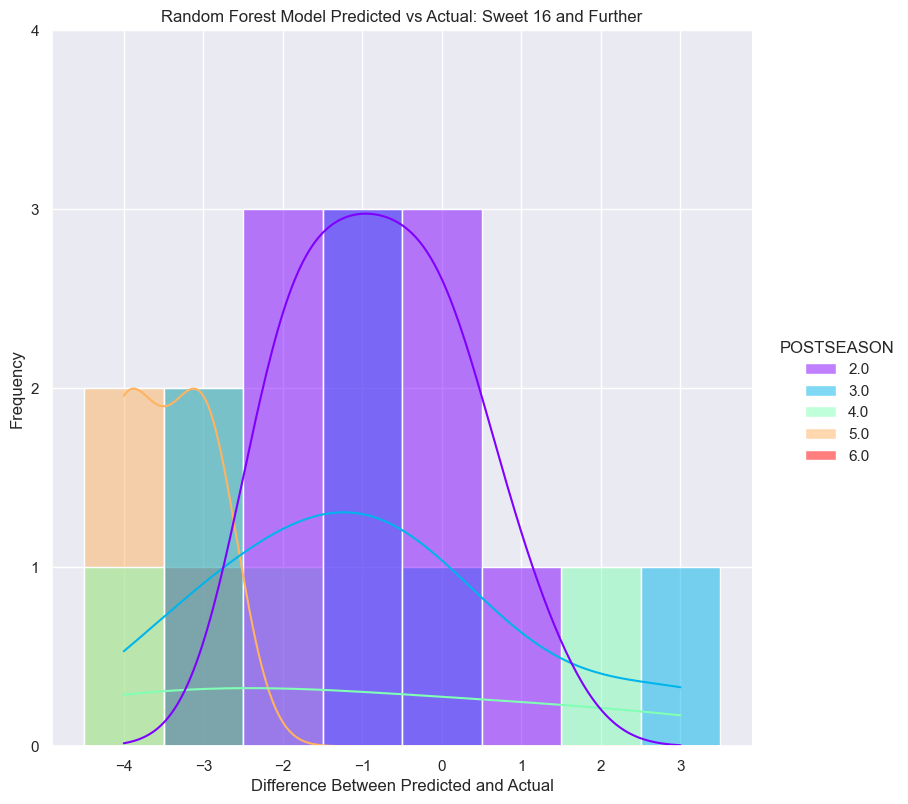

In [183]:
test_data_eval_edited = test_data_eval[test_data_eval['POSTSEASON'] > 1.0]

sns.set_theme(context='notebook', style='darkgrid')

sns.displot(test_data_eval_edited, x='DIFF', hue='POSTSEASON', kde=True, palette='rainbow', discrete=True, height = 8)

plt.yticks(range(0, 5, 1))
plt.xlabel('Difference Between Predicted and Actual')
plt.ylabel('Frequency')
plt.title('Random Forest Model Predicted vs Actual: Sweet 16 and Further')
plt.show()

Underpredicting even moreso for teams who actually make it further. 

### 5.4 View Feature Importance

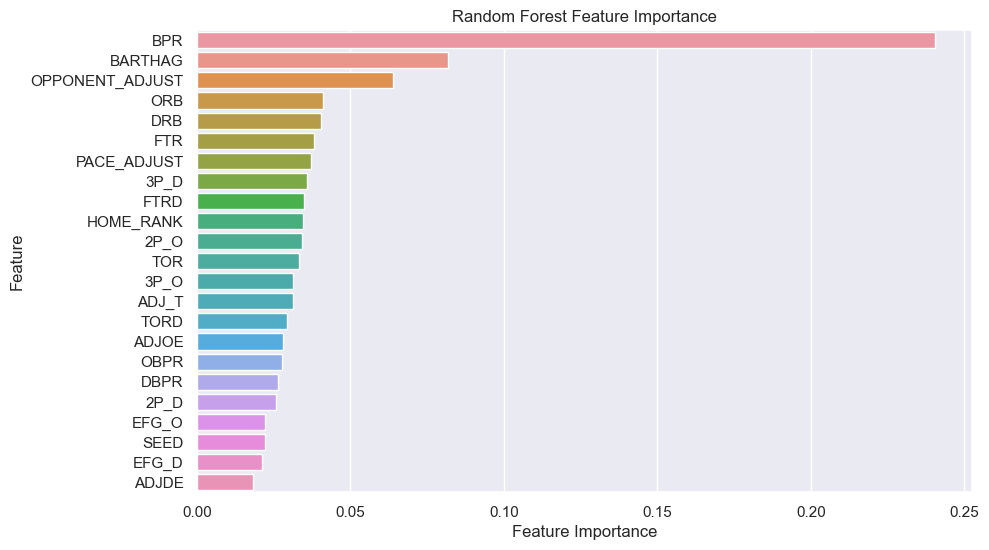

In [184]:
import joblib 
rf = joblib.load('../models/rf.pkl')
feature_importance = rf.feature_importances_
feature_names = X.columns  

# Sort feature importances and feature names in ascending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Create a horizontal bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance, y=sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()